In [ ]:
!pip install faker
!pip install kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.4 MB/s eta 0:00:00


In [ ]:

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType
from  faker  import Faker
import random
import kaleido
spark = SparkSession.builder.appName("MovieRatingsAnalysis").getOrCreate()
fake = Faker()


In [ ]:

def generate_data(num_records=100000):
    return [
        (random.randrange(1, 51),  # MovieID (1 to 50)
         random.randrange(1, 201),  # UserID (1 to 200)
         round(random.uniform(1.0, 5.0), 1),  # Rating (1.0 to 5.0)
         int(fake.unix_time(start_datetime="-2y")))  # Optimized Faker Unix Timestamp
        for _ in range(num_records)
    ]
schema = StructType([
    StructField("MovieID", IntegerType(), True),
    StructField("UserID", IntegerType(), True),
    StructField("Rating", FloatType(), True),
    StructField("Timestamp", IntegerType(), True)
])
data = generate_data(1000)
df = spark.createDataFrame(data, schema=schema)
df.show(5)


+-------+------+------+----------+
|MovieID|UserID|Rating| Timestamp|
+-------+------+------+----------+
|     47|   132|   2.3|1717338637|
|      2|    90|   3.8|1698999513|
|      8|    73|   1.5|1699016982|
|     10|   179|   3.4|1713409270|
|     26|    58|   3.3|1698345189|
+-------+------+------+----------+
only showing top 5 rows



In [ ]:
from pyspark.sql import functions as F
average = df.groupBy("MovieID").agg(F.avg("Rating").alias("Average_Rating"))
average.show(5)


+-------+------------------+
|MovieID|    Average_Rating|
+-------+------------------+
|     31|3.0476190476190474|
|     34|2.3076922985223622|
|     28|3.5181818387725134|
|     26| 3.026315814570377|
|     27|2.6368421127921655|
+-------+------------------+
only showing top 5 rows



In [ ]:

tot_count = df.groupBy("UserID").agg(F.count("UserID").alias("MoviesRated"))
users = tot_count.filter(tot_count.MoviesRated > 5)
users.show(5)


+------+-----------+
|UserID|MoviesRated|
+------+-----------+
|   108|          8|
|   101|          6|
|    81|          6|
|    76|          8|
|    26|          7|
+------+-----------+
only showing top 5 rows



In [ ]:

avg_ratings = df.groupBy("MovieId").agg(F.avg("Rating").alias("AvgRating"))
top5 = avg_ratings.orderBy(F.col("AvgRating").desc()).limit(5)
top5.show()


+-------+------------------+
|MovieId|         AvgRating|
+-------+------------------+
|     28|3.5181818387725134|
|     42|3.4333333571751914|
|      5|3.4315790000714754|
|     24| 3.353333322207133|
|     48| 3.300000006953875|
+-------+------------------+



In [ ]:
from pyspark.sql.functions import count
import plotly.express as px
user_counts = df.groupBy("UserID").agg(count("MovieID").alias("MoviesRated"))
user_counts_pd = user_counts.toPandas()
fig = px.histogram(user_counts_pd,
                   x="MoviesRated",
                   nbins=20,
                   title="Users vs. Number of Movies Rated",
                   labels={"MoviesRated": "Number of Movies Rated", "count": "Number of Users"},
                   opacity=0.75)
fig.show()
fig.write_image("ratings_distribution.png")

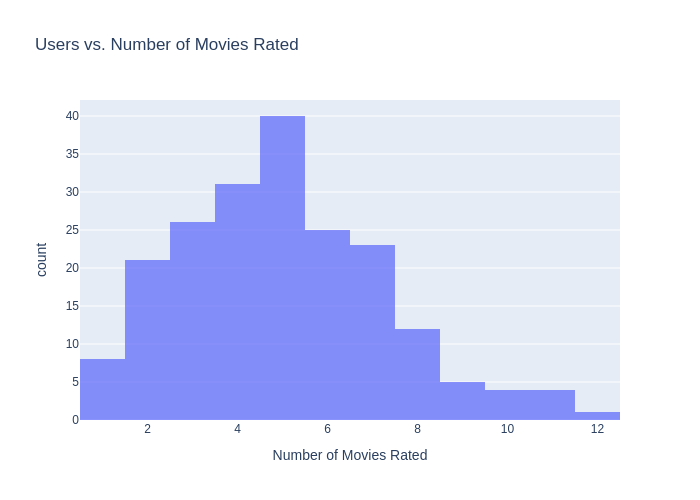

In [ ]:
from IPython.display import display, Image
display(Image(filename="ratings_distribution.png"))
